# Modèles dynamiques pour la gestion énergétique des bâtiments - Groupe SEM 7

Ce notebook présente une simulation thermique dynamique d’un bâtiment simplifié, modélisé avec 5 murs identiques à deux couches, un mur vitré, une infiltration d’air et un contrôle de température. 

Le code se trouve en annexe à la fin du document.

L'objectif est de modéliser thermiquement ce bâtiment à l'aide d'équations différentielles algébriques.


## Modèle et Steady-State

Nous décidons de modéliser notre bâtiment comme ci-dessous, avec 2 pièces différentes séparées par une porte en bois de chêne. La grande salle possède un mur vitré et fait 20m² tandis que la petite salle fait elle 6.25m². Le HVAC intéragit avec les deux pièces.

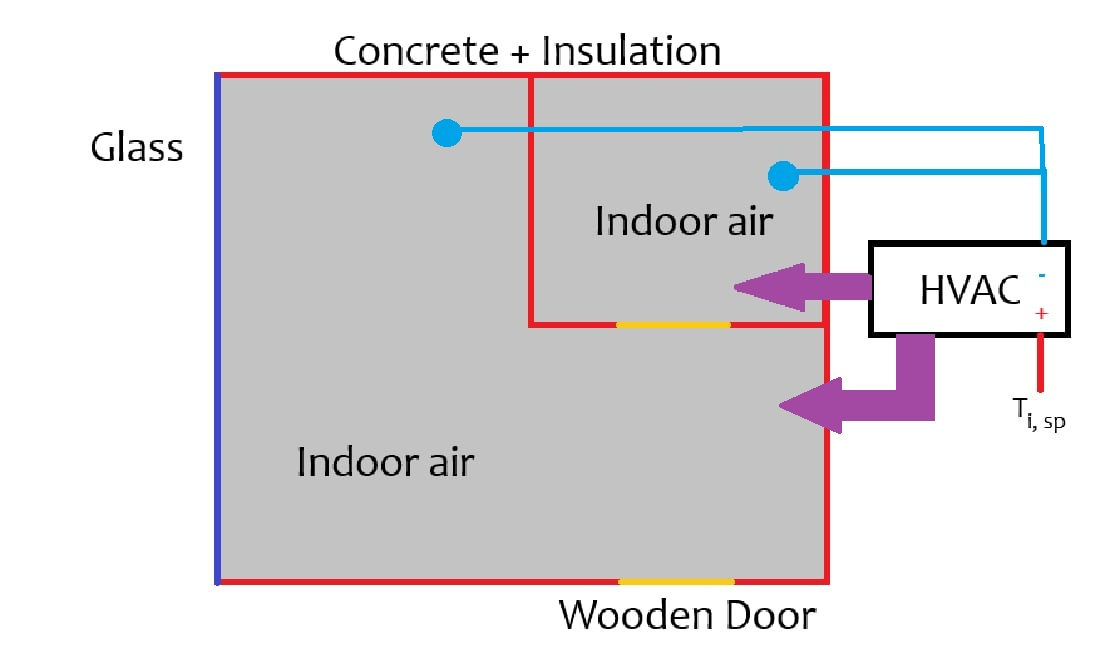





Nous pouvons créer une modélisation électrique de ce bâtiment comme ci-dessous :

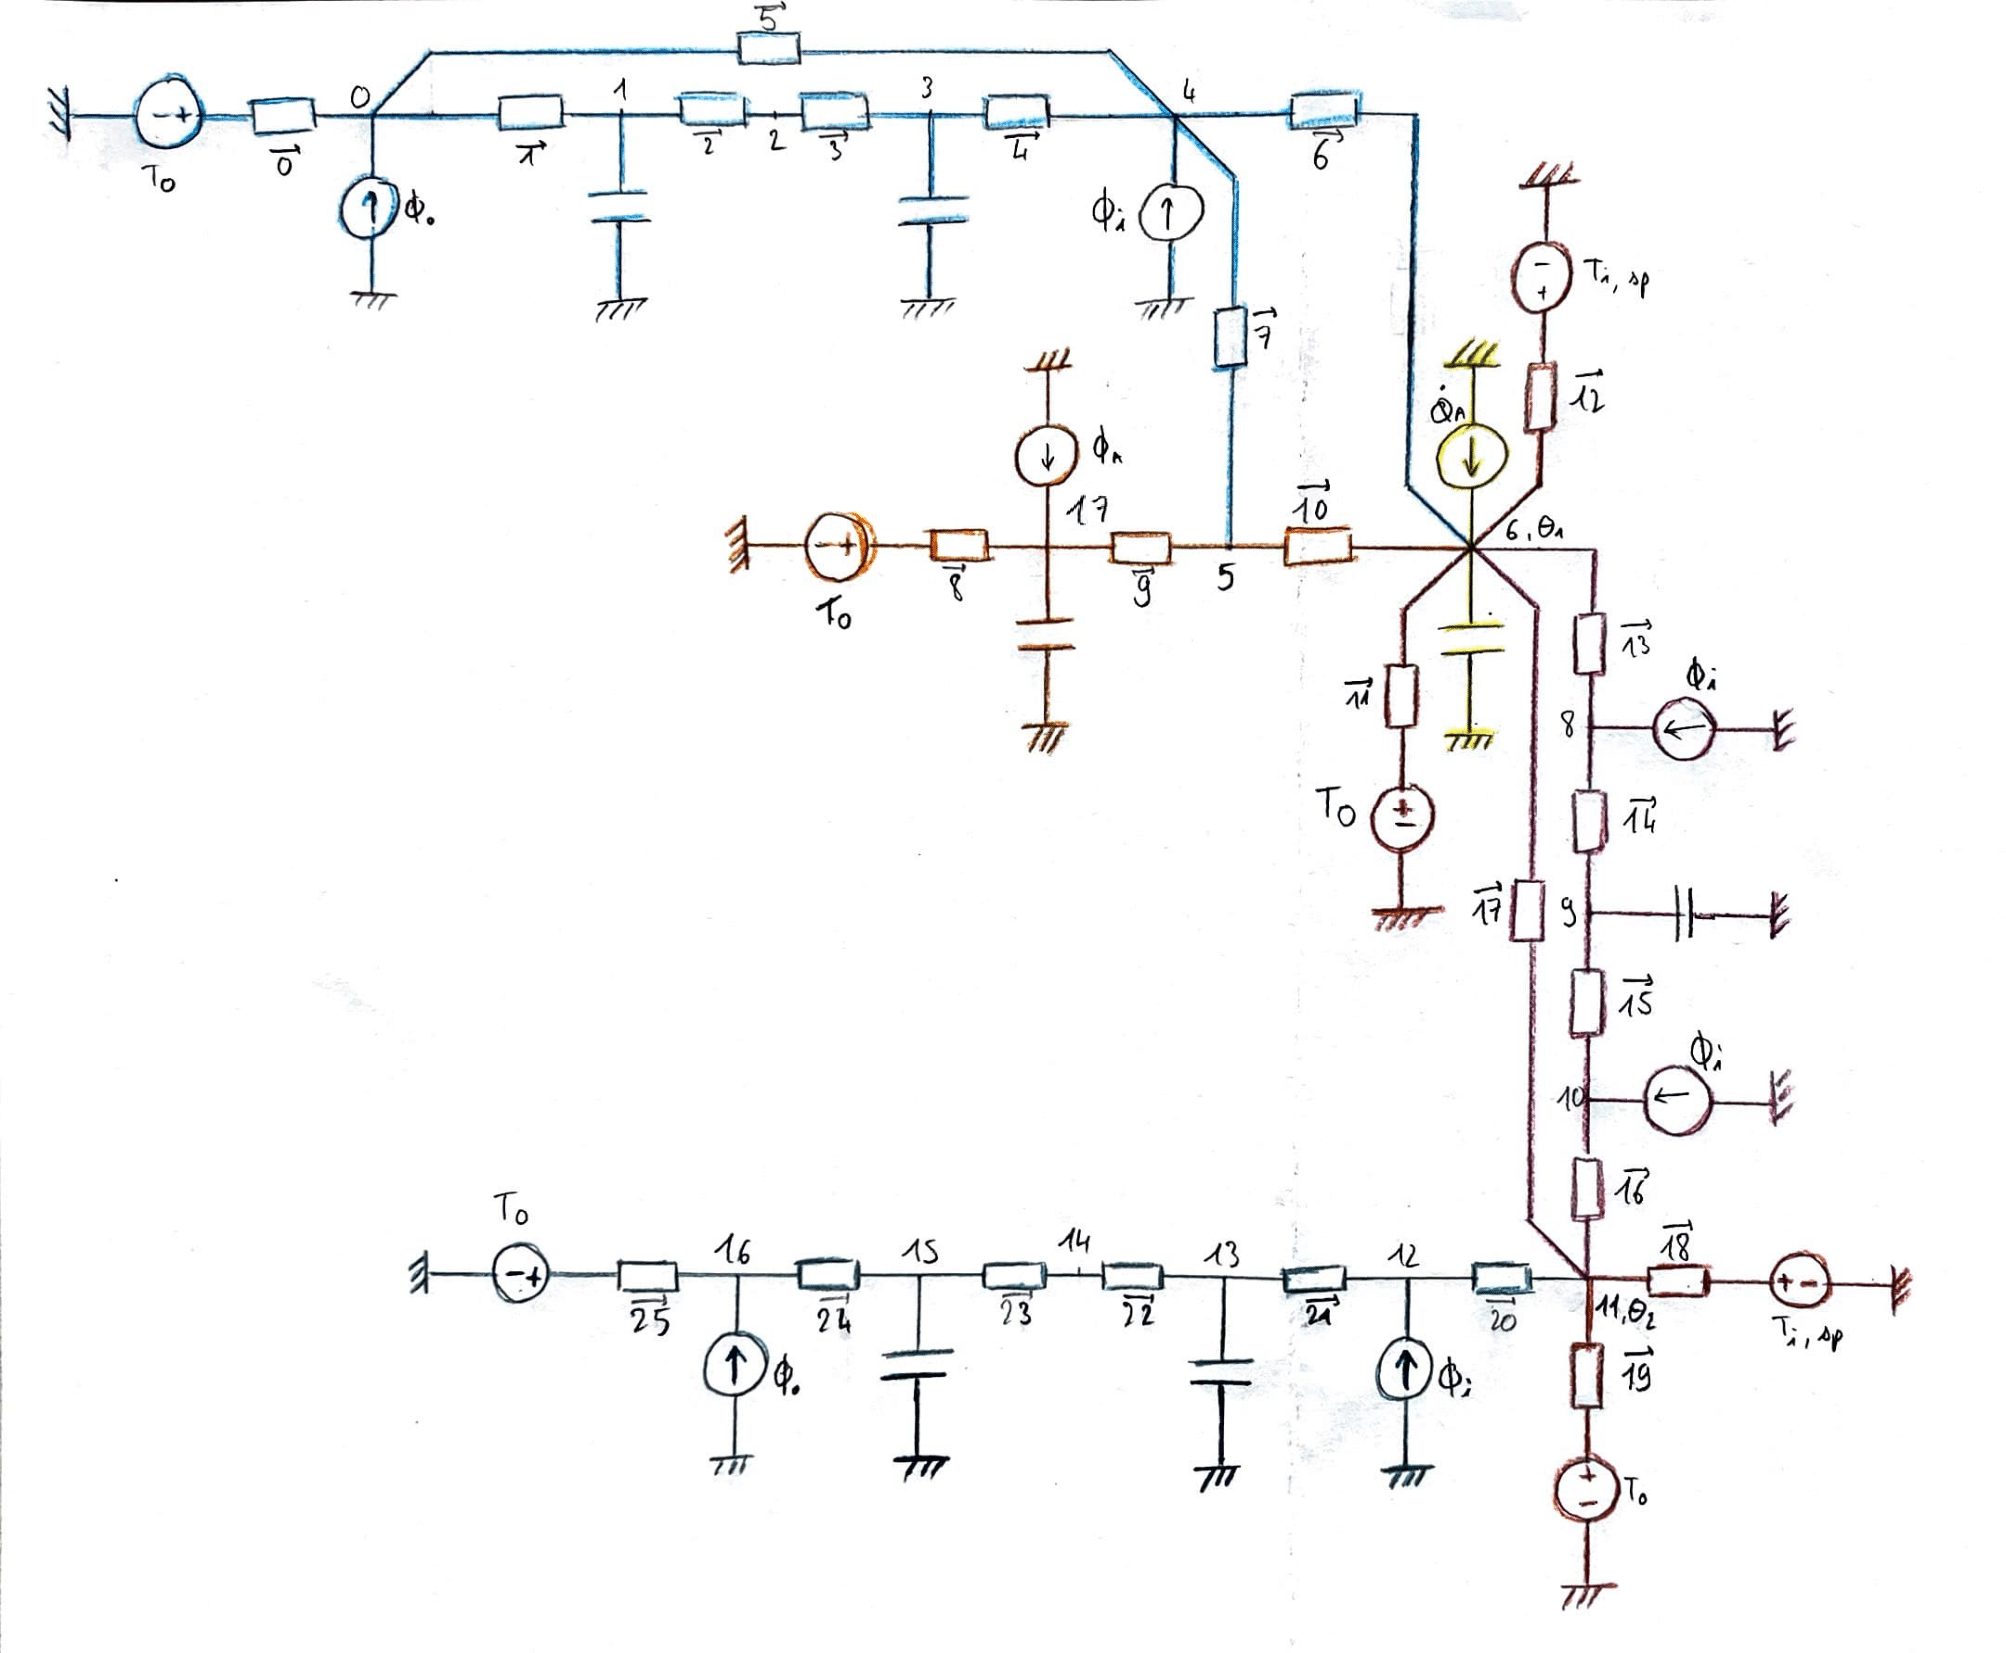

La légende est la suivante : 

    - Bleu = Mur isolé entre pièce principale et extérieur
    
    - Orange = Mur vitré
    
    - Jaune = Electroménager dans la pièce principale
    
    - Rouge = Ventilation + HVAC
    
    - Mauve = Mur intérieur
    
    - Vert = Mur extérieur de la pièce secondaire
    

À partir de ce schéma, nous calculons les différentes matrices : 
    -Matrice d'incidence A
    -Matrice de conductance G
    -Matrice de capacité C

Tout en définissant les entrées : les sources de température (vecteur b) et les sources de débit (vecteur f).

Tout cela sera fait de la même manière que dans l'exemple ci-dessous : 

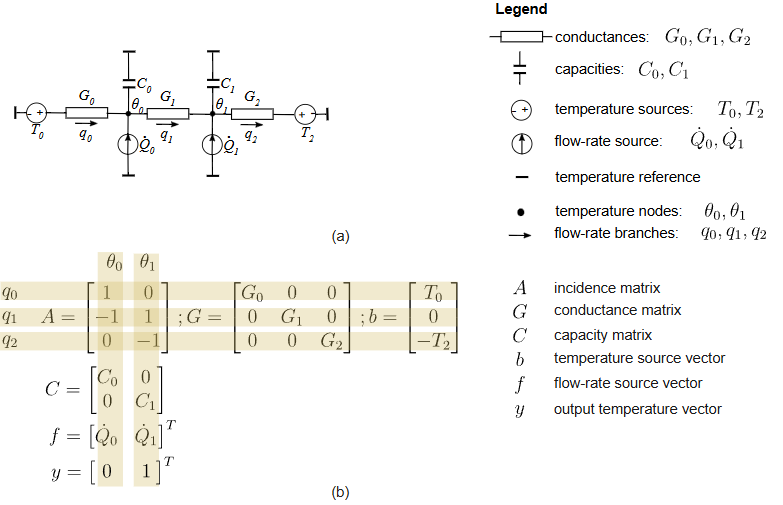

Nous voulons ensuite transformer ces équations algébriques différentielles (DAE) en représentation space-state :

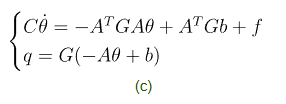

Nous simulerons ensuite la réponse à un échelon puis la réaction aux conditions météorologiques.

### CODE

In [2]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 12 21:31:57 2023

@author: cghiaus

Thermal circuit and state-space representation for a thermal circuit
with capacities in some nodes: cubic building
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem


# Physical analysis
# =================
l = 5               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

# Thermo-physical properties
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

wall = {'Conductivity': [1.4, 0.027, 1.4, 0.18],  # W/(m·K)
        'Density': [2300, 55, 2500, 85],        # kg/m³
        'Specific heat': [880, 1210, 750, 2380],  # J/(kg·K)
        'Width': [0.2, 0.08, 0.004, 0.05],
        'Surface': [5 * l**2, 5 * l**2, l**2, 1.935],  # m²
        'Slices': [2, 1, 1, 2]}                # number of  slices
wall1 = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass','Oak'])

concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 5 * l**2}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.08,
              'Surface': 5 * l**2}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': l**2}

oak = {'Conductivity': 0.18,               # W/(m·K)
         'Density': 85,                   # kg/m³
         'Specific heat': 2380,             # J/(kg⋅K)
         'Width': 0.05,                     # m
         'Surface': 1.935}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Oak': oak},
                              orient='index')

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
ε_oLW = 0.90    # long wave emmisivity: oak
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

# convection coefficients
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

# Thermal circuit
# ===============
# thermal conductances
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
G_door =oak['Conductivity'] / oak['Width'] * oak['Surface']

# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
Go = h * wall['Surface'][3]    # door

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
GLW3 = 4 * σ * Tm**3 * ε_oLW / (1 - ε_oLW) * wall['Surface']['Oak']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2 + 1 / GLW3)

# ventilation & advection
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

Gv = air['Density'] * air['Specific heat'] * Va_dot

# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

# temperature nodes
nθ = 18      # number of temperature nodes
θ = [f'θ{i}' for i in range(18)]

# flow-rate branches
nq = 26     # number of flow branches
q = [f'q{i}' for i in range(26)]
# glass: convection outdoor & conduction

Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

# Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

# System of algebraic-differential equations (DAE)
# ================================================
A = np.zeros([26,18])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1   # branch 1: node 0 -> node 1
A[5,0], A[5,4] = -1, 1
A[2,1],A[2,2]= -1, 1
A[3,2], A[3,3]= -1, 1
A[4,3],A[4,4]=-1, 1
A[6,4],A[7,4]=-1, -1
A[7,5]=1
A[6,6]=1
A[8,17]=1
A[9,17]=-1
A[9,5]=1
A[10,5]=-1
A[10,6]=1
A[11,6]=1
A[12,6]=1
A[13,6]=1
A[13,8]=-1
A[14,8]=1
A[14,9]=-1
A[15,9]=1
A[15,10]=-1
A[16,10]=1
A[16,11]=-1
A[17,11]=-1
A[17,6]=1
A[18,11]=1
A[19,11]=1
A[20,11]=1
A[20,12]=-1
A[21,12]=1
A[21,13]=-1
A[22,13]=1
A[22,14]=-1
A[23,14]=1
A[23,15]=-1
A[24,15]=1
A[24,16]=-1
A[25,16]=1


G = np.zeros((26,26))
G[0,0]=Gw['out']
G[1,1]=G[2,2]=G[25,25]=G[24,24]= 2 * G_cd['Layer_out']
G[3,3]=G[4,4]=G[21,21]=G[22,22]=G[13,13]=G[14,14]=G[15,15]=G[16,16]=2 * G_cd['Layer_in']
G[5,5]=G[17,17]=2*G_door
G[7,7]=GLW
G[6,6]=Gw['in']
G[10,10]=Gg['in']
G[8,8]= Ggs
G[9,9]=2 * G_cd['Glass']
G[11,11]=G[19,19]=Gv
G[12,12]=G[18,18]=Kp
G=np.diag(G)


# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

neglect_air_glass = False

b = np.zeros(26)        # branches
b[[0, 8, 11, 12,18,19,25]] = 1   # branches with temperature sources

f = np.zeros(18)         # nodes
f[[0, 4, 6, 17, 8, 10, 12, 16]] = 1     # nodes with heat-flow sources

y = np.zeros(18)         # nodes
y[[6,11]] = 1              # nodes (temperatures) of interest

# State-space representation
# ==========================
# Créer la capacité thermique C comme une matrice (15x15)
neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0,0,C['Layer_in'],0,0,0,C['Layer_in'],0,C['Layer_out'],0,0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], 0,0,C['Layer_in'],0,0,0,C['Layer_in'],0,C['Layer_out'],0,C['Glass']])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

# f et y comme vecteurs simples (numpy)
f = np.zeros(18)
f[[0, 4, 6, 7, 8, 10, 12, 14]] = 1

y = np.zeros(18)
y[[6, 12]] = 1

# Création du dictionnaire et appel
TC = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

[As, Bs, Cs, Ds] = dm4bem.tc2ss(TC)

# Steady-state
# ============
# from system of DAE
b = np.zeros(22)        # temperature sources
b[[0, 8, 11, 20]] = 10      # outdoor temperature
b[[21]] = 20            # indoor set-point temperature

f = np.zeros(15)         # flow-rate sources

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

# from state-space representation
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

# Dynamic simulation
# ==================
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / 3600:.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')

u = np.zeros([15, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='$Time$ [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

# Simulation with weather data
# ----------------------------
# Input vector
# weather data
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

# solar radiatiion on the walls
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
rad_surf['Etot'] = rad_surf.sum(axis=1)

# resample the weather data
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

# other inputs
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Etot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']

# Initial conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

# Time integration
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

# outputs
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

# plot
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()


/tmp/ipykernel_491/1248002441.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Gw = h * wall['Surface'][0]     # wall
/tmp/ipykernel_491/1248002441.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Gg = h * wall['Surface'][2]     # glass
/tmp/ipykernel_491/1248002441.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Go = h * wall['Surface'][3]    # door
/tmp/ipykernel_491/1248002441.py:124: FutureWarning: Calling float on 

ValueError: matrices are not aligned